In [2]:
import numpy as np

In [3]:
class Line:
	def __init__(self, a=(0,0), b=(1,0)):
		self.a = np.array(a, dtype=float)
		self.b = np.array(b, dtype=float)

	@property
	def bbox(self):
		return (self.a[0], self.a[1], self.b[0], self.b[1])
		
	@property
	def coefs(self):
		"""Returns (p,q,r) of the line px+qy=r passing through points a and b"""
		ab = self.a - self.b
		q = -ab[0]
		p = ab[1]
		r = p*self.a[0] + q*self.a[1]
		return (p,q,r)
		
	@property
	def vec_perp(self):
		c = self.coefs
		n = np.array([c[0], c[1]])
		n /= np.linalg.norm(n)
		return n

	@property
	def vec_para(self):
		c = self.coefs
		m = np.array([-c[1], c[0]])
		m /= np.linalg.norm(m)
		return m
		
	@staticmethod
	def parallel(l1, l2):
		c1, c2 = l1.coefs, l2.coefs
		return iszero(c1[0]*c2[1] - c2[0]*c1[1])
		
	@staticmethod
	def intersection(l1, l2):
		c1, c2 = l1.coefs, l2.coefs
		det = c1[0]*c2[1] - c2[0]*c1[1]
		rhs = np.array([
			c1[2]*c2[1] - c2[2]*c1[1],
			c1[0]*c2[2] - c2[0]*c1[2]
		])
		return rhs/det

	@staticmethod
	def is_inter_on_sgmt(inter, line):
		"""Tests whether a line intersection lies on a line segment"""
		return (min(line.a[0], line.b[0]) <= inter[0] <= max(line.a[0], line.b[0])) and (min(line.a[1], line.b[1]) <= inter[1] <= max(line.a[1], line.b[1]))

In [4]:
# TODO : oldpos mixin

class Ball:
    def __init__(self, pos=(0,0), vel=(0,0)):
        self.pos = np.array(pos, dtype=float)
        self.pos_old = self.pos
        self.pos_hist = []
        self.vel = np.array(vel, dtype=float)

In [5]:
class World:
    def __init__(self, lines=[], balls=[]):
        self.lines = lines
        self.balls = balls
        
    def integrate(self, dt):
        for ball in self.balls:
            ball.pos_old = np.array(ball.pos)
            ball.pos += ball.vel * dt
            
    def resolve_collision(self, ball):
        ignored_lines = []
        inters = []
        
        while True:
            # Compute all intersection points with the lines in the trajectory and test if it lies on both segments
            inters = []
            for line in self.lines:
                if line in ignored_lines:
                    continue
                l1 = Line(a=ball.pos_old, b=ball.pos)
                l2 = line
                pt = Line.intersection(l1, l2)
                if Line.is_inter_on_sgmt(pt, l1) and Line.is_inter_on_sgmt(pt, l2):
                    inters.append((pt, line))
                    
            if len(inters) == 0:
                # No collision to be resolved
                break
                
            dists = [np.linalg.norm(pt-ball.pos_old) for (pt, line) in inters]
            ignored_lines = []
            for i, (inter, line) in enumerate(inters):
                # Find intersection closest to the old ball position within a tolerance
                # This is done to deal with "perfect corner" situations
                if dists[i] - min(dists) > 1e-15:
                    continue

                # Compute the correction
                diff = ball.pos - inter
                n, m = line.vec_perp, line.vec_para
                newpos = inter - np.dot(n, diff)*n + np.dot(m, diff)*m
                newvel = -np.dot(n, ball.vel)*n + np.dot(m, ball.vel)*m

                # Resolve collision (with the closest line)
                # Snap ball to intersection point. At this point the ball is "inside" the closed shape
                ball.pos_old = inter
                ball.pos = newpos
                ball.vel = newvel

                ball.pos_hist.append(ball.pos_old)

                # Resolve the rest of the collisions (ball may have crossed multiple lines in one step)
                # Since the oldpos is on the line, the next iteration will always consider that collision point and the program hangs
                ignored_lines.append(line)
            
    def step(self, dt):
        self.integrate(dt)
        for ball in self.balls:
            self.resolve_collision(ball)

In [6]:
import matplotlib.pyplot as plt

In [7]:
def plot_line(line, ax, **kwargs):
    ax.plot([line.a[0], line.b[0]], [line.a[1], line.b[1]], **kwargs)
    
def plot_vec(vec, ax, orig=(0, 0), **kwargs):
    ax.plot([orig[0], orig[0]+vec[0]], [orig[1], orig[1]+vec[1]], **kwargs)
    
def plot_ball(ball, ax):
    ax.plot(*ball.pos, '.', color='tab:gray')
    plot_vec(ball.vel, ax, orig=ball.pos, color='tab:gray')
    
def plot_hist(ball, ax, **kwargs):
    pos_hist = np.array(ball.pos_hist)
    ax.plot(pos_hist[:, 0], pos_hist[:, 1], **kwargs)

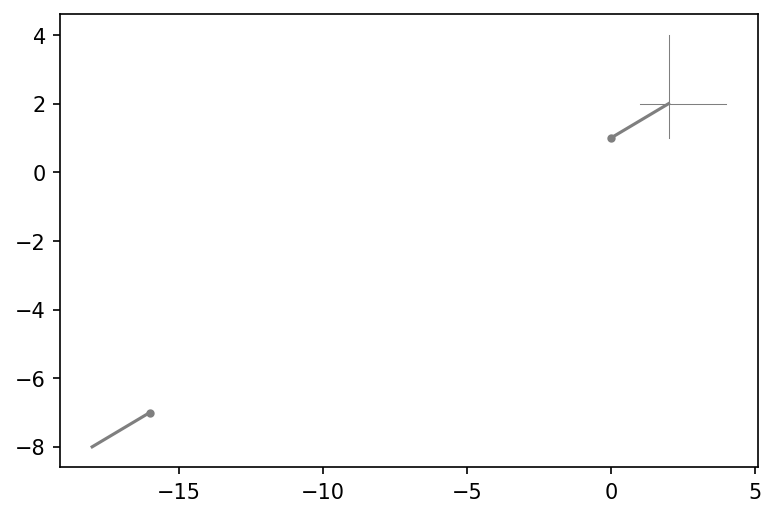

In [20]:
fig, ax = plt.subplots(dpi=150)
# ax.set_aspect('equal')

world = World(
#     lines=[
#         Line(a=(0, 0), b=(50, 0)),
#         Line(a=(0, 1), b=(50, 1)),
#         Line(a=(0, 0.2), b=(50, 1))
#     ],
#     lines=[
#         Line(a=(0, 0), b=(8, 0)),
#         Line(a=(8, 0), b=(10, 6)),
#         Line(a=(10, 6), b=(1, 5)),
#         Line(a=(1, 5), b=(0, 0))
#     ],
    lines=[
        Line(a=(2, 1), b=(2, 4)),
        Line(a=(1, 2), b=(4, 2))
    ],
    balls=[Ball(pos=(0, 1), vel=(2, 1))]
)

for line in world.lines:
    plot_line(line, ax, color='tab:gray', linewidth=0.5)
    
pos_list = []
pos_list.append(world.balls[-1].pos)
plot_ball(world.balls[-1], ax)
world.step(10)
plot_ball(world.balls[-1], ax)
plot_hist(world.balls[-1], ax, linewidth=1)

plt.show()
plt.close()

# Testing Line

In [9]:
l1 = Line(a=(-1, 0), b=(1, 0))
l2 = Line(a=(0, -1), b=(0, 1))

print(l1.coefs, l2.coefs, sep='\n')

(0.0, 2.0, 0.0)
(-2.0, -0.0, 0.0)
